In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/train.csv


In [46]:
# 경고 무시 (쓸데없는 로그 출력금지)
import warnings
warnings.filterwarnings('ignore')

# 그래프 관련 
import matplotlib.pyplot as plt
import seaborn as sns



# 학습
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPool2D, Flatten, Dense, Softmax
from keras.preprocessing import image

from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, K
from keras.models import Input, Model
from sklearn.model_selection import StratifiedKFold

from keras.preprocessing.image import ImageDataGenerator
import gc

########################
# Seed All
# import numpy as np
import tensorflow as tf
import random
# import os
# from keras import backend as K
import warnings
from keras.callbacks import Callback
from datetime import datetime
from pytz import timezone, utc

In [47]:
## load data
inputdir='../input/Kannada-MNIST/'
outputdir='./'

dftrain = pd.read_csv(inputdir+'train.csv')
dftest = pd.read_csv(inputdir+'test.csv')
dfsub = pd.read_csv(inputdir+'sample_submission.csv')

In [48]:
dftrain.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
dftest.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
nptrain = np.asarray(dftrain.iloc[:,1:].values)
print('test shape=', nptrain.shape)

nptest = np.asarray(dftest.iloc[:,1:].values)
print('test shape=', nptest.shape)

test shape= (60000, 784)
test shape= (5000, 784)


In [51]:
nptrain=nptrain.reshape((-1,28,28,1))
print('train shape=', nptrain.shape)
nptest=nptest.reshape((-1,28,28,1))
print('test shape=', nptest.shape)

train shape= (60000, 28, 28, 1)
test shape= (5000, 28, 28, 1)


In [52]:
def image_show(npdata, labels, cnt, brandom=True):
    plt.figure(figsize=(6*cnt, 6))
    if brandom:
        idx=np.random.randint(0,npdata.shape[0], cnt)
    else:
        idx=np.arange(cnt)
    for i in range(cnt):
        plt.subplot(1,cnt, i+1)
        plt.title(labels[idx[i]])
        imgdata = npdata[idx[i]].squeeze()
        plt.imshow(imgdata, cmap='gray')
    plt.show()

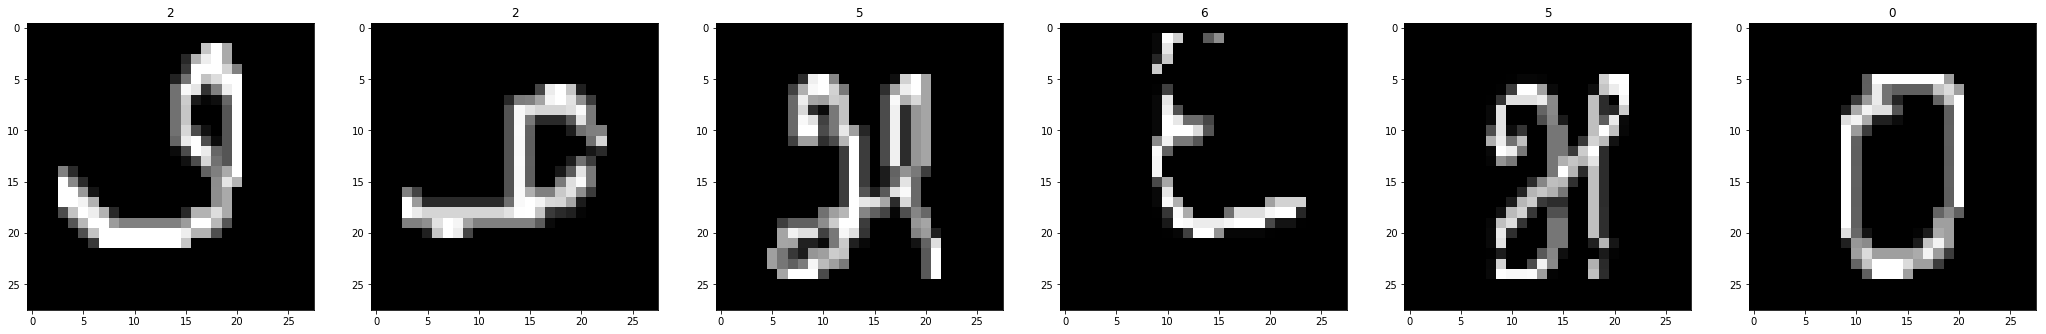

In [53]:
# train 이미지 랜덤 보기    
image_show(nptrain, dftrain.label, 6)

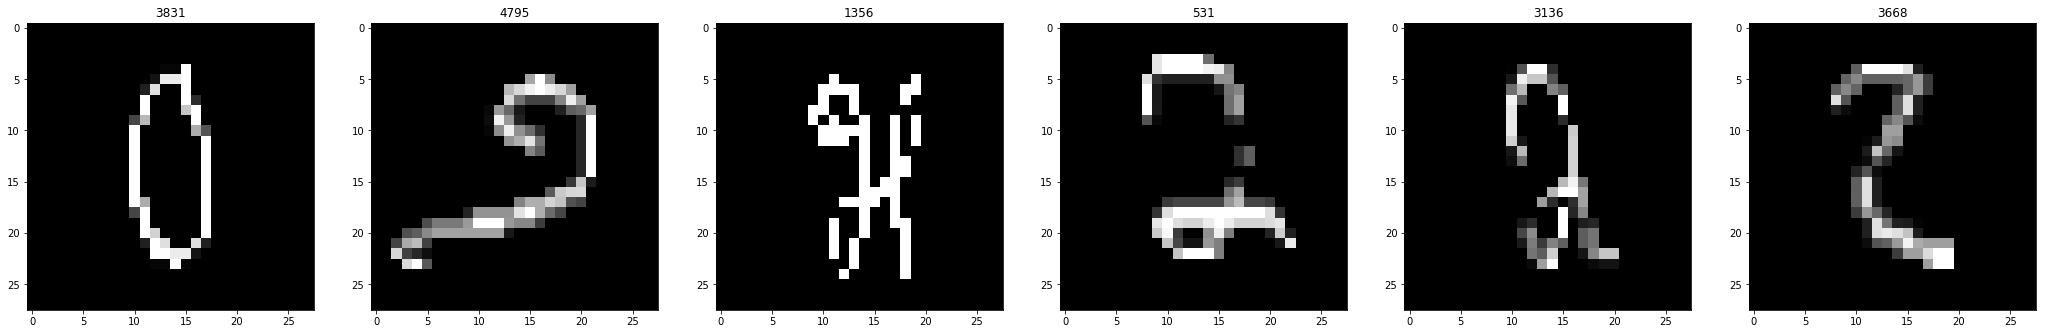

In [54]:
# test 이미지 랜덤 보기
image_show(nptest, dftest.id, 6)

In [55]:
dftrain.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

## Image Augument

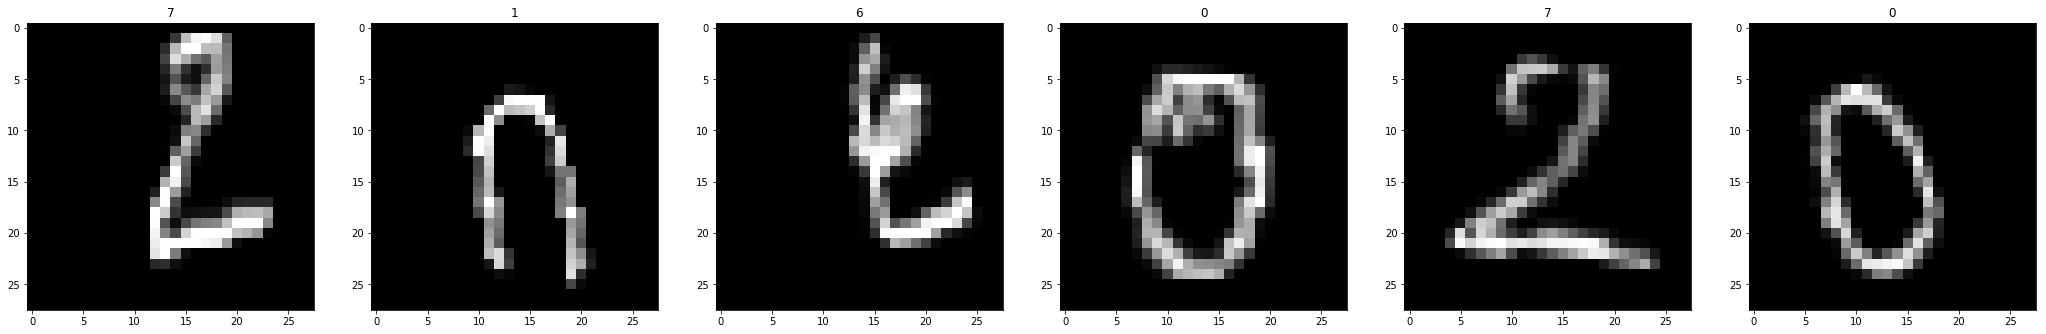

In [56]:
datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, 
                              horizontal_flip=False, vertical_flip=False,
                              width_shift_range=0.1, height_shift_range=0.1, 
                              rotation_range=15, brightness_range=[0.5, 1.2],
                              fill_mode='nearest')
datagen2 = ImageDataGenerator(rescale=1./255)

datagen1.fit(nptrain)
for xbatch, ybatch in datagen1.flow(nptrain, dftrain['label'], batch_size=6):
    image_show(xbatch, ybatch, 6, False)
    break   


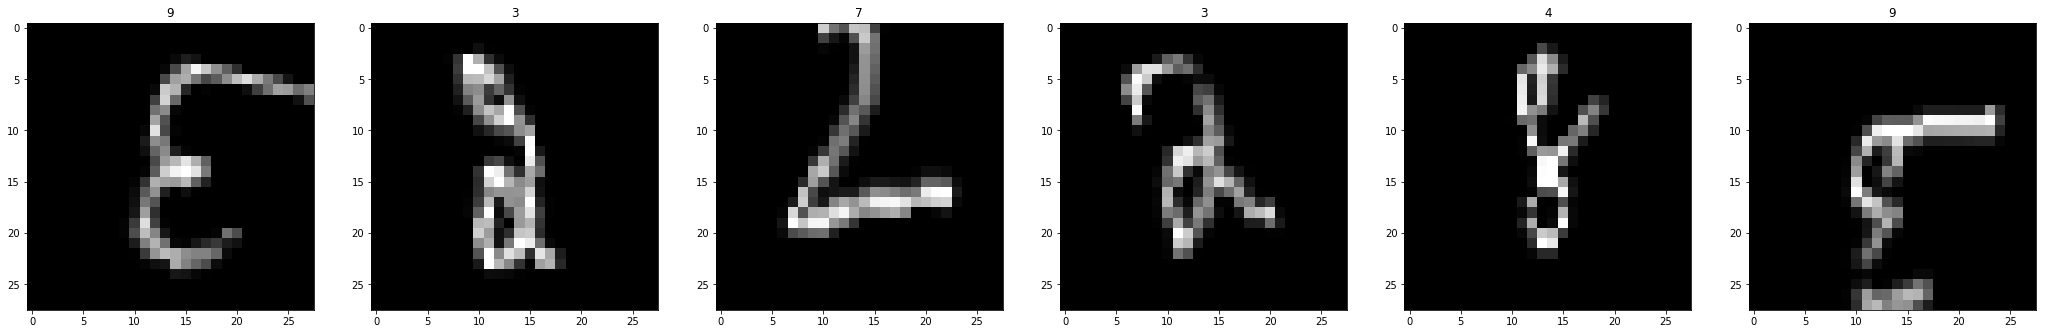

In [57]:
for xbatch, ybatch in datagen1.flow(nptrain, dftrain['label'], batch_size=6):
    image_show(xbatch, ybatch, 6, False)
    break   


## Train


In [58]:
KST = timezone('Asia/Seoul')

def dbgprint(msg):
    os.system(f'echo \"{msg}\"')
    print(msg) 

class EpochLogWrite(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        tmx = utc.localize(datetime.utcnow()).astimezone(KST).time()
        dbgprint('Epoch #{} begins at {}'.format(epoch+1, tmx))
    def on_epoch_end(self, epoch, logs={}):
        tmx = utc.localize(datetime.utcnow()).astimezone(KST).time()
        dbgprint('Epoch #{} ends at {}  acc={} val_acc={} '.format(epoch+1, tmx, round(logs['acc'],4), round(logs['val_acc'],4)))


SEED=1234
dbgprint('hello world. SEED={}'.format(SEED))

def seed_All():
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    tf.set_random_seed(SEED)
    sess = tf.Session(graph=tf.get_default_graph(), config=config)
    K.set_session(sess)

seed_All()


hello world. SEED=1234


In [59]:
#######################
# configure
bDebug=True
curFold = 1  # make current fold (1..fold_k)
batch_size=32  # 16, 32, 64  debug.. memory dependent!
# K fold
fold_k = 6
imagesize=28

In [60]:
if bDebug:
    print('Debug Version!!!! ')
    print('Fast Fast. Only use 1000 items in train.')
    dftrain = dftrain[:1000]
    nptrain = nptrain[:1000]


Debug Version!!!! 
Fast Fast. Only use 1000 items in train.


In [61]:
# 라벨 클래스를 스트링으로 변경
# dftrain['label'] = dftrain['label'].astype('str')
classes = list (str(num) for num in range(0, 10))
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [62]:
method = 'conv'
modelname = 'kannada-v1-'
modellist = ['kannada-v5-1-', 'kannada-v5-2-', 'kannada-v5-3-', 
             'kannada-v5-4-', 'kannada-v5-5-', 'kannada-v5-6-']

In [63]:
skf = StratifiedKFold(fold_k, random_state=SEED)

In [65]:
kk=0
for modelname, (tri, tei) in zip(modellist, skf.split(nptrain, dftrain['label'])):
    kk+=1
    # 아래를 주석처리하면 전체 모델 생성으로 오랜 시간 소요.
    # curFold (1~6) 해당 모델 1개만 생성.
    if kk != curFold:
        continue
    dbgprint('Make Model={}'.format(kk))

    modelpath = outputdir+modelname+method+'-{epoch:03d}-{val_new_score:.4f}.ckpt'
    print(modelpath)
    
    nptrain_t = nptrain[tri,:]
    nptrain_v = nptrain[tei,:]
    
#     nptrain_t3 = np.stack([nptrain_t]*3, axis=-1)
#     nptrain_v3 = np.stack([nptrain_v]*3, axis=-1)
#     nptrain_t3=nptrain_t3.reshape(-1,28,28,3)
#     nptrain_v3=nptrain_v3.reshape(-1,28,28,3)
    
    dflabel_t = np_utils.to_categorical(dftrain.loc[tri]['label'])
    dflabel_v = np_utils.to_categorical(dftrain.loc[tei]['label'])
#     print(nptrain_t3.shape, nptrain_v3.shape)
    
    datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, 
                                  horizontal_flip=False, vertical_flip=False,
                                  width_shift_range=0.1, height_shift_range=0.1, 
                                  rotation_range=15, brightness_range=[0.5, 1.2],
                                  fill_mode='nearest')
    datagen2 = ImageDataGenerator(rescale=1./255)
    
    datagen1.fit(nptrain_t)
    train_generator = datagen1.flow(nptrain_t, dflabel_t, batch_size=batch_size,seed=SEED,  shuffle=True)
    val_generator = datagen1.flow(nptrain_v, dflabel_v, batch_size=batch_size,shuffle=False)   
    
    ### checkpoint save weights in progress...
    cp_callback = ModelCheckpoint(modelpath,  monitor='val_score', mode='max', save_best_only=True, save_weights_only=True)
    es_callback = EarlyStopping(monitor='val_score',  mode='max', patience=20)

    # tensorboard log
    if not os.path.exists('log'):
        os.mkdir('log')
    tensorboard = TensorBoard(log_dir='log/'+str(time.time()))

    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (4,4),padding = 'Same', activation ='relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 256, kernel_size = (4,4),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (4,4),padding = 'Same', activation ='relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    model.summary()
    

#     cblist = [tensorboard, cp_callback, es_callback, EpochLogWrite()]
    cblist = [EpochLogWrite()]
    epochs=20
    hist = model.fit_generator( train_generator, initial_epoch=0, epochs = epochs, validation_data=val_generator, 
                               callbacks=cblist, steps_per_epoch=len(tri)/batch_size, validation_steps=len(tei)/batch_size)
    
    model.save(outputdir+'model.h5')
    
    
    

Make Model=1
./kannada-v5-1-conv-{epoch:03d}-{val_new_score:.4f}.ckpt
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 28, 28, 32)        544       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropou

KeyboardInterrupt: 